# Filtering marker data example

> Alex Woodall <br>
> Auckland Bioengineering Institute <br>
> University of Auckland, New Zealand

There are two main features that need to be filtered. It is necessary to filter motion capture data to attempt to remove any soft tissue artefact or other recording noise. If this is not done before numerical differentiation during inverse kinematics/dynamics, high frequency noise will be amplified.

![alt text](images/inverse_dynamics.png "Title")

We also must filter the force plate data at the same frequency to the motion caputre data for dynamic consistancy.

Start by importing the libraries needed to run the task.

In [1]:
# Import the necessary libraries
import sys
import matplotlib.pyplot as plt
from scipy import signal
%matplotlib notebook

sys.path.insert(1, r'./../Functions') # add functions to path

from read_trc import read_trc

## Reading in a TRC file

We can read in the desired trc file, containing the coordinate data for each of the markers during a motion capture recording session.

In [4]:
# Read trc file using 'read_trc'. The file is structured as a dictionary.
# See 'readTRC' in the functions file for more information.
mkr_data = read_trc()

## Filtering

### Marker of interest

Before we can filter any marker data, we (obviously) have to choose a marker to filter! One of the markers that I've always been interested in, and I'm sure you have too, is the left shank lateral marker. As such, we'll use this marker for the example.

In [ ]:
# Pull out a marker of interest
L_shank_lateral = mkr_data["Data"]["Markers"]["LShankLateral"]["All"]


### Choosing filter parameters

To build a filter, we need a few parameters. The data capture rate is already given to us in the TRC file, so we'll use that. <br>
We also have to choose an appropriate cut-off frequency to perform a low-pass filter.

Signal frequencies of common activites are shown here:

| Movement Activity  | Max. Frequency of Interest  |
|---|---|
| Posture  | 3 Hz  |
| Gait (excluding heelstrike transient)  | 6 Hz  |
| Running  | 10 Hz - 30 Hz  |
| Heelstrike Transient  | 100 Hz - 300 Hz|

Most activity during gait occurs at 6 Hz or below, so choosing a cut-off frequency around this range is good for a gait trial. However, we will lose data from the heelstrike transient.

In [5]:
# To assign the appropriate filter, we need to specify the data capture rate as well as the desired cut-off frequency
data_rate = mkr_data["Information"]["DataRate"]
cut_off_frequency = 6 # Let's choose 6 Hz to begin with

### Filtering

With everything set-up, all that is left is to fil-... determine the filter coefficients and then filter!

This requires getting the critical frequency from the cut-off frequency but dividing by half the data capture rate.

We will be using an infinite impulse response (IIR) digital filter which outputs $b$ and $a$. These are the numerator and denominator polynomials of the IIR filter transfer function respectively.

$H(z) = \frac{Y(z)}{X(z)} = \frac{b_0 + b_1z^{-1}+...+b_Mz^{-M}}{1 + a_1z^{-1}+...+a_Nz^{-N}}$

Luckily for us, the computer does the maths for us.

Once we have $b$ and $a$, we can filter the marker data using a forward-backward filter. This type of filter applies a linear filter twice, once forward and once backwards. The combined filter has linear phase.

In [40]:
# Determine filter coefficients
Wn = cut_off_frequency/(data_rate/2)
b, a = signal.butter(2, Wn)

In [45]:
# Filter data
L_shank_lateral_filt = signal.filtfilt(b, a, L_shank_lateral,axis=0)

## Plotting

We can now visualise the results to see how good the filtering was. Displayed here is the $y$ coordinate data, but feel free to change the code to look at the $x$ and $z$ coordinate data.

<IPython.core.display.Javascript object>


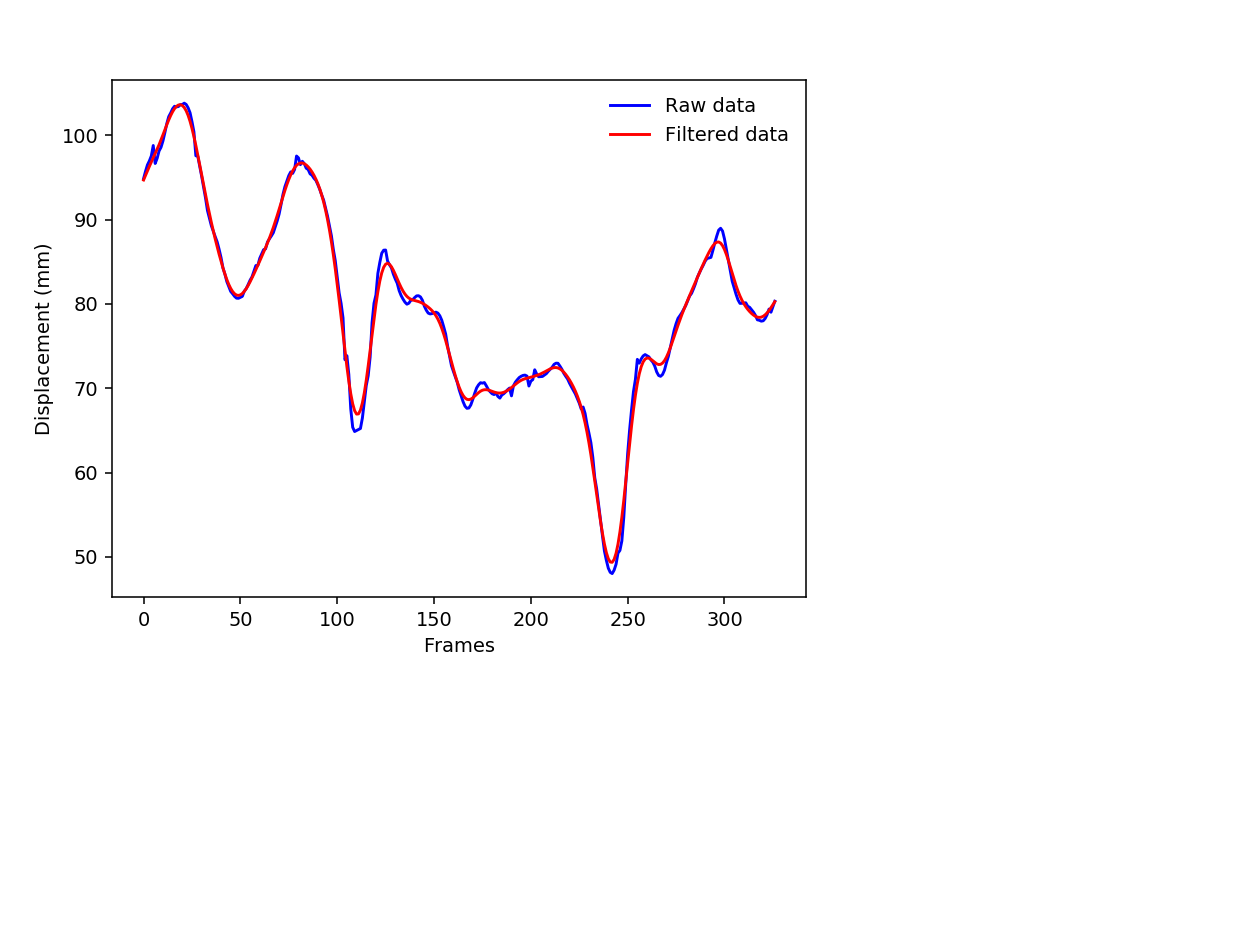

In [53]:
# Plot the results and compare the filtered data with the raw data
fig, ax = plt.subplots(1, 1)
ax.plot(L_shank_lateral[:,1],'b',label = 'Raw data')
ax.plot(L_shank_lateral_filt[:,1],'r', label = 'Filtered data')

ax.legend(frameon=False)
ax.set_xlabel('Frames')
ax.set_ylabel('Displacement (mm)')

plt.show()
